In [110]:
import eli5
import cv2
from PIL import Image
from IPython.display import display
from eli5.ipython import show_prediction
import tensorflow as tf
import numpy as np
# you may want to keep logging enabled when doing your own work
import logging
import tensorflow as tf
# tf.get_logger().setLevel(logging.ERROR) # disable Tensorflow warnings for this tutorial
import warnings
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import DenseNet201,ResNet50

warnings.simplefilter("ignore")  # disable Keras warnings for this tutorial
# import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from IPython.display import Image, display # For displaying images

import tensorflow as tf # Import TensorFlow
from tensorflow import keras # Import Keras

In [111]:
from aspp import ConvBlock

[[[ 69  80  84]
  [ 65  76  80]
  [ 74  85  89]
  ...
  [ 92 107 116]
  [ 94 109 118]
  [ 98 113 122]]

 [[ 82  93  97]
  [ 79  90  94]
  [ 86  97 101]
  ...
  [ 97 112 121]
  [100 115 124]
  [102 117 126]]

 [[ 91 102 106]
  [ 91 102 106]
  [103 114 118]
  ...
  [ 99 114 123]
  [100 115 124]
  [101 116 125]]

 ...

 [[ 85 100 103]
  [ 90 105 108]
  [ 97 112 115]
  ...
  [ 64  73  77]
  [ 64  73  77]
  [ 63  72  76]]

 [[ 82  97 100]
  [ 90 105 108]
  [ 97 112 115]
  ...
  [ 30  39  43]
  [ 37  46  50]
  [ 46  55  59]]

 [[ 82  97 100]
  [ 90 105 108]
  [ 97 112 115]
  ...
  [ 32  41  45]
  [ 42  51  55]
  [ 57  66  70]]]


(-0.5, 255.5, 255.5, -0.5)

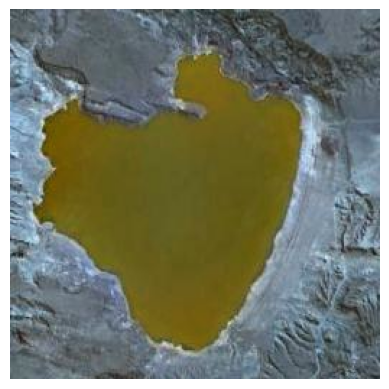

In [112]:
# filename = 'D:/COVID/X_Ray_Image_DataSet/Raw/Covid-19/jkms-35-e79-g001-l-c.jpg'
filename = 'C://Users/csitaula/Desktop/onedrive/Aerial/NWPU_/2_8/1/val/lake/lake_006.jpg'
# filename ="D:/COVID/X_Ray_Image_DataSet/Raw/Pneumonia/00000573_008.png"
orignal = cv2.imread(filename)
print(orignal)
plt.imshow(orignal)
plt.grid('off')
plt.axis('off')

In [113]:
# model = load_model('C:/Users/csitaula/PycharmProjects/TGRSLetters/trained_model_AID_fold1_2_8_GRSL1.h5'
# ,custom_objects={'ConvBlock': ConvBlock})  # load the saved model
model=ResNet50(weights='imagenet',include_top=True,input_shape=(224,224,3))

In [114]:
print(model.summary())

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_8[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [115]:
image_size = (224, 224)
#last_conv_layer_name = "batch_normalization_37"
last_conv_layer_name="conv5_block3_out"#concatenate_8"

In [116]:
def get_image_array(img_path, img_size):
    img = keras.preprocessing.image.load_img(img_path, target_size=img_size) # Load the image through image path
    img_array = keras.preprocessing.image.img_to_array(img) # Converting image to array
    img_array = np.expand_dims(img_array, axis=0) # Expanding one dimension of the image size
    return img_array

In [117]:
def generate_gradcam_heatmap(image_array, model, last_conv_layer_name, pred_index=None):
    grad_model = keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    ) # maps the input image to the activations of the last conv layer

    with tf.GradientTape() as tape: # Compute the gradient of the top predicted class
        last_conv_layer_output, preds = grad_model(image_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel in the feature map array
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap) # Normlising the heatmap between 0 & 1
    return heatmap.numpy()

(1, 224, 224, 3)


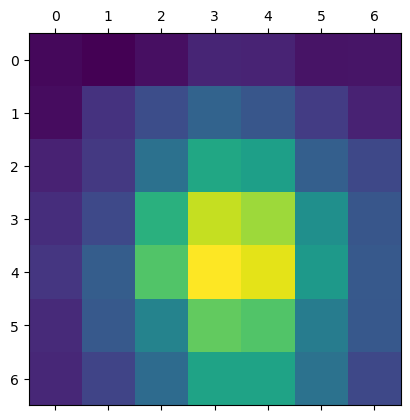

In [118]:
#image_array = keras.applications.xception.preprocess_input(get_image_array(image_path, size=image_size)) # Preprocess the input image
import cv2
# path="C://Users/csitaula/Desktop/onedrive/Aerial/AID_/2_8/1/val/Airport/airport_1.jpg"
original=cv2.imread(filename)
resized = cv2.resize(original, (224, 224))
dataXG = np.array(resized) / 255.0
img_array = np.expand_dims(dataXG, axis=0)
print(img_array.shape)


#model = keras.applications.xception.Xception(weights="imagenet") # Build the model
model=model
#model.layers[-1].activation = None # Remove the last layer's activation function

prediction = model.predict(img_array)
#print("Predicted:", keras.applications.xception.decode_predictions(prediction, top=1)[0]) # Print the top prediction

heatmap = generate_gradcam_heatmap(img_array, model, last_conv_layer_name) # Display the heatmap
plt.matshow(heatmap)
plt.show()

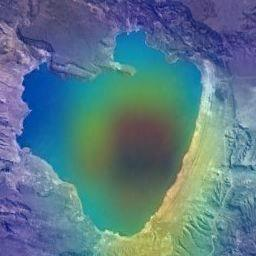

In [119]:
def save_and_display_gradcam(image_path, heatmap, cam_path="grad-cam.jpg", alpha=0.4):
    img = keras.preprocessing.image.load_img(image_path) # Loading the original image
    img = keras.preprocessing.image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap) # Rescale heatmap to a range between 0 and 255
    
    jet = cm.get_cmap("jet") # Use jet colormap to colorize heatmap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap) # Creating an image with RGB colorized heatmap
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    superimposed_image = jet_heatmap * alpha + img # Superimposing the heatmap on original image
    superimposed_image = keras.preprocessing.image.array_to_img(superimposed_image)

   
    superimposed_image.save(cam_path)  # Save the image
    display(Image(cam_path)) # Display Grad-CAM


save_and_display_gradcam(filename, heatmap)

In [120]:
print(filename)

C://Users/csitaula/Desktop/onedrive/Aerial/NWPU_/2_8/1/val/lake/lake_006.jpg
